In [1]:
# ! if [ ! $pip_done ]; then pip install -q transformers ;fi 

# # command-line
# # pip uninstall folium
# ! pip install folium==0.2.1

# ! if [ ! $pip_done ]; then pip install -q datasets jiwer ;fi 
# ! if [ ! $pip_done ]; then pip install -q sentencepiece ;fi 

# pip_done = 1

In [1]:
# Testing parameters: Only run on N samples if test=True
max_sample_test = 1000
# Maximum length of equation in # of tokens
max_length_token = 100
# Size of vocab in tokenizer, i.e. distinct number of tokens to learn
vocab_size = 600
# Batch size for DataLoader
batch_size = 16
# Version number for model
version = 5
# Report loss every N steps
report_step = 100 
# Number of epochs to train. Each epoch is one cycle of training over full training set.
num_epoch = 5

In [2]:
# IPython magic to enable inline display of matplotlib plots
%matplotlib inline
from IPython.display import Image as ipyImage
from IPython.display import display, Latex

In [3]:
def preprocess_df(pth, type = None):
    df = pd.read_csv(join(data_dir, pth), header=None, sep=' ')
    df = df.drop(2, axis=1)
    df.rename(columns={0: "text_index", 1: "file_name"}, inplace=True)

    # Replace text with formulas
    df['text'] = df.apply (lambda row: formulas[int(row['text_index'])], axis=1)
    df['len'] = df.apply (lambda row: row['text'].count(' '), axis=1)
    # Sort by ascending length of formula
    df_sorted = df.sort_values(by="len")
    df_filtered = df_sorted[df_sorted['len'] > 0 ]
    df_trunc = df_filtered[df_filtered['len'] <= max_length_token ]
    df = df_trunc
    df = df.reset_index(drop=True)
    globals()["{}_df".format(type)] = df
    # print(type+'_dataframe',df.head())

In [4]:
import pandas as pd
from os.path import join

data_dir = './data/'

# formulas_file = join(data_dir, "im2latex_formulas.lst")
# with open(formulas_file, 'r', encoding='ISO-8859-1') as f:
#     formulas = [formula.strip('\n') for formula in f.readlines()]

formulas_file = join(data_dir, "im2latex_formulas_utf.lst")
# linux 인코딩 변환 : iconv -c -f ISO-8859-1 -t utf-8 im2latex_formulas.lst > im2latex_formulas_utf.lst
with open(formulas_file, 'r') as f:
    formulas = [formula.strip('\n') for formula in f.readlines()]

# train_df/test_df/validate_df
types = ['train', 'test', 'validate']
for type in types:
    pth = 'im2latex_{}.lst'.format(type)
    preprocess_df(pth, type = type)
    

55435    H_{D7} =  \frac{h_{D_{7}}}{2\ell}|x_{2}^{2}| +...
Name: text, dtype: object


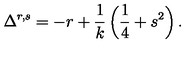

In [5]:
from PIL import Image
# Truncate data for testing
if test: train_df = train_df.truncate(after=max_sample_test-1)
# Show some images as sanity check
sample = train_df.sample(n=1)
print(sample['text'])
# ipyImage는 출력이 안되는 오류 자주 발생
# ipyImage(join(data_dir, 'formula_images_processed', sample.iloc[0]['file_name']+".png"))
image = Image.open(join(data_dir, 'formula_images_processed', sample.iloc[0]['file_name']+".png"))
image

In [6]:
# Create and train word level tokenizer
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
max_length = max_length_token
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.enable_padding(length=max_length)
tokenizer.enable_truncation(max_length=max_length)

from tokenizers.trainers import WordLevelTrainer
trainer = WordLevelTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"],
                     vocab_size=vocab_size,
                     show_progress=True,
                     )


In [7]:
from tokenizers.pre_tokenizers import Whitespace
tokenizer.pre_tokenizer = Whitespace()

from tokenizers.processors import TemplateProcessing
tokenizer.post_processor = TemplateProcessing(
    single="[CLS] $A [SEP]",
    pair="[CLS] $A [SEP] $B:1 [SEP]:1",
    special_tokens=[
        ("[CLS]", 1),
        ("[SEP]", 2),
    ],
)

files = [formulas_file]
tokenizer.train(files, trainer)

tokenizer.save("tokenizer-wordlevel.json")

In [8]:
# Sanity check of tokenizer
i = 5

print( tokenizer.encode(train_df.loc[i, 'text']).tokens )

print( tokenizer.encode(train_df.loc[i, 'text']).ids )

print( tokenizer.token_to_id("[PAD]") )


['[CLS]', '{\\', 'cal', 'L', '}=\\', 'frac', '{', '1', '}{', '2', '}\\', 'partial_', '{\\', 'mu', '}\\', 'phi', '\\', 'partial', '^{\\', 'mu', '}\\', 'phi', '+\\', 'frac', '{', '1', '}{', '2', '}\\', 'partial_', '{\\', 'mu', '}\\', 'chi', '\\', 'partial', '^{\\', 'mu', '}\\', 'chi', '-', 'U', '(\\', 'phi', ',\\', 'chi', '),', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
[1, 9, 46, 93, 136, 14, 6, 10, 23, 8, 13, 102, 9, 27, 13, 54, 5, 48, 32, 27, 13, 54, 76, 14, 6, 10, 23, 8, 13, 102, 9, 27, 13, 172, 5, 48, 32, 27, 13, 172, 16, 179, 30, 54, 49, 172, 176, 2, 0, 0,

In [9]:
import torch
from torch.utils.data import Dataset
from PIL import Image

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, tokenizer, max_target_length=max_length):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name+'.png').convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
#        # add labels (input_ids) by encoding the text
#        labels = self.processor.tokenizer(text, 
#                                          padding="max_length", 
#                                          max_length=self.max_target_length).input_ids
#        # important: make sure that PAD tokens are ignored by the loss function
#        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        labels = self.tokenizer.encode(text).ids
        labels = [label if label != self.tokenizer.token_to_id("[PAD]") else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

/Users/jeeyoon/miniforge3/envs/imlatex/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from transformers import TrOCRProcessor
root_dir = join(data_dir, 'formula_images_processed/',) 
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-small-printed", Use_fast= False)
train_dataset = IAMDataset(root_dir=root_dir,
                           df=train_df,
                           processor=processor,
                           tokenizer=tokenizer)
valid_dataset = IAMDataset(root_dir=root_dir,
                           df=validate_df,
                           processor=processor,
                           tokenizer=tokenizer)
eval_dataset = IAMDataset(root_dir=root_dir,
                           df=test_df,
                           processor=processor,
                           tokenizer=tokenizer)

In [11]:
print("Number of training examples:", len(train_dataset))
print("Number of training examples:", len(valid_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 78024
Number of training examples: 8638
Number of validation examples: 9699


pixel_values torch.Size([3, 384, 384])
labels torch.Size([100])


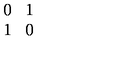

In [14]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)
image = Image.open(train_dataset.root_dir + train_df['file_name'][0]+'.png').convert("RGB")
image

In [15]:
labels = encoding['labels']
labels[labels == -100] = tokenizer.token_to_id("[PAD]")
label_str = tokenizer.decode(labels.tolist(), skip_special_tokens=True)
print(label_str)

\ label { eq : }{\ cal U } _ {\ hat { U }\ hat { V }}= 0 .


In [16]:
batch_size = 16
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=batch_size)
validate_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Train the model

In [17]:
from transformers import VisionEncoderDecoderModel
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-small-stage1")
model.to(device)


Downloading:   0%|          | 0.00/4.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/235M [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-small-stage1 and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0): DeiTLayer(
          (attention): DeiTAttention(
            (attention): DeiTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_features=

In [18]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = tokenizer.token_to_id("[CLS]")
model.config.pad_token_id = tokenizer.token_to_id("[PAD]")
# make sure vocab size is set correctly
model.config.vocab_size = vocab_size

# set beam search parameters
model.config.eos_token_id = tokenizer.token_to_id("[SEP]")
model.config.max_length = max_length #64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [19]:
model.tokenizer = tokenizer

In [20]:
from datasets import load_metric

cer_metric = load_metric("cer")


In [21]:
from datasets import load_metric

cer_metric = load_metric("cer")

def compute_cer(pred_ids, label_ids):
    pred_str = tokenizer.decode_batch(pred_ids.tolist(), skip_special_tokens=True)
    label_ids[label_ids == -100] = tokenizer.token_to_id("[PAD]")
    label_str = tokenizer.decode_batch(label_ids.tolist(), skip_special_tokens=True)
    
    # Filter out empty label strings
#    for l in enumerate(label_str):
#        if not l:
#            label_str.pop(l)
#            pred_str.pop(l)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return cer


In [22]:
 num_epoch = 5
 report_step = 100 
 
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

for epoch in range(num_epoch):  # loop over the dataset multiple times
   # train
   model.train()
   train_loss = 0.0
   for i, batch in enumerate(tqdm(train_dataloader)):
      # get the inputs
      for k,v in batch.items():
        batch[k] = v.to(device)

      # forward + backward + optimize
      outputs = model(**batch)
      loss = outputs.loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      train_loss += loss.item()
      if i % report_step == 0: print(f"Loss: {loss.item()}") 

   print(f"Loss after epoch {epoch}:", train_loss/len(train_dataloader))
   model.save_pretrained(f"version_{version}/epoch_{epoch}")
    

model.save_pretrained(f"version_{version}/final")

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/4877 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: './data/formula_images_processed/74eb7c041b.png'

In [ ]:
test_dataloader = DataLoader(eval_dataset, batch_size=1, shuffle=True)

i = 0
for batch in (test_dataloader):
    for k,v in batch.items():
        batch[k] = v.to(device)
    outputs = model.generate(batch["pixel_values"].to(device))
    px = batch["pixel_values"][i].cpu().numpy()
    labels = batch["labels"][i]
    pred = outputs[i]
    break

import matplotlib.pyplot as plt
plt.imshow(px.transpose([1,2,0]), aspect=1/5)
label_true = tokenizer.decode(labels.tolist()).replace(" ", "")
label_pred = tokenizer.decode(pred.tolist()).replace(" ", "")

print( 'True label: ' + label_true )
print( 'Pred. label: ' + label_pred )
# print( pred.tolist() )

pred_latex = Latex(f'${label_pred}$')
display(pred_latex)

In [ ]:
# evaluate
model.eval()
valid_cer = 0.0
with torch.no_grad():
    for i, batch in enumerate(tqdm(eval_dataloader)):
        # run batch generation
        outputs = model.generate(batch["pixel_values"].to(device))
        # compute metrics
        cer = compute_cer(pred_ids=outputs, label_ids=batch["labels"])
        
        valid_cer += cer

print("Validation CER:", valid_cer / len(eval_dataloader))

In [ ]:
def get_pred_and_label_str(pred, label):
    pred_str = tokenizer.decode_batch(pred.tolist(), skip_special_tokens=True)
    label[label == -100] = tokenizer.token_to_id("[PAD]")
    label_str = tokenizer.decode_batch(label.tolist(), skip_special_tokens=True)
    return (pred_str, label_str)

In [ ]:
import nltk
candidate_corpus = []
references_corpus = []
valid_bleu = 0.0

with torch.no_grad():
    for i, batch in enumerate(tqdm(eval_dataloader)):
        # run batch generation
        outputs = model.generate(batch["pixel_values"].to(device))
        # compute metrics
        pred, label = get_pred_and_label_str(outputs, batch["labels"])
        
        for s in pred: s = s.split(" ")
        for s in label: s = s.split(" ")
        candidate_corpus.extend(pred)
        references_corpus.extend(label)
    
valid_bleu =  nltk.translate.bleu_score.corpus_bleu(
        references_corpus, candidate_corpus,
        weights=(0.25, 0.25, 0.25, 0.25)
)
valid_bleu

In [ ]:
!v=$version; cp tokenizer-wordlevel.json version_$$v/final
!v=$version; tar zcvf version_$$v.tar.gz --directory=version_$$v/final 